### 1D convolutional model

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("jena_climate_2009_2016.csv")

In [3]:
temperature = df["T (degC)"].values

In [4]:
raw_data = df.loc[:, "p (mbar)":"wd (deg)"].values

**Data split**

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

**Normalizing the data**

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**Instantiating datasets for training, validation, and testing**

In [7]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [8]:
train_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [9]:
inputs = Input(shape=(sequence_length, raw_data.shape[-1]))
x = Conv1D(8, 24, activation="relu")(inputs)
x = MaxPooling1D(2)(x)

x = Conv1D(8, 12, activation="relu")(x)
x = MaxPooling1D(2)(x)

x = Conv1D(8, 6, activation="relu")(x)
x = GlobalAveragePooling1D()(x)

outputs = Dense(1)(x)

model = Model(inputs, outputs)

callbacks = [ModelCheckpoint("jena_cnn.keras", save_best_only=True)]

In [10]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 17s 11ms/step - loss: 22.1375 - mae: 3.6679 - val_loss: 18.2880 - val_mae: 3.3449
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 14.9569 - mae: 3.0761 - val_loss: 14.8291 - val_mae: 3.0176
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 13.7745 - mae: 2.9482 - val_loss: 14.3157 - val_mae: 2.9644
Epoch 4/10
819/819 [==============================] - 9s 10ms/step - loss: 12.9631 - mae: 2.8577 - val_loss: 15.3642 - val_mae: 3.0948
Epoch 5/10
819/819 [==============================] - 9s 10ms/step - loss: 12.4411 - mae: 2.8002 - val_loss: 14.3185 - val_mae: 2.9920
Epoch 6/10
819/819 [==============================] - 9s 10ms/step - loss: 11.9878 - mae: 2.7491 - val_loss: 15.6073 - val_mae: 3.0927
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 11.6198 - mae: 2.7041 - val_loss: 15.3009 - val_mae: 3.0775
Epoch 8/10
819/819 [==============================] - 

In [11]:
model = load_model("jena_cnn.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 3s 6ms/step - loss: 15.9365 - mae: 3.1134
Test MAE: 3.11


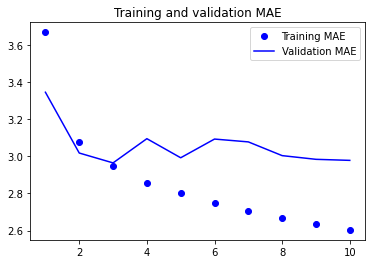

In [12]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()